In [4]:
import numpy as np
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
import pandas as pd

# Importing Data and Initial Plots

In [8]:
from scipy import stats

samplingRate = 2200
startIdx =  155
input_data = pd.read_csv('Dataset/Raw Data.csv',header=None).to_numpy()
output_data = pd.read_csv('Dataset/Artifact Data.csv',header=None).to_numpy()
coordinates = pd.read_csv('Dataset/Coordinates.csv',header=None)
categories = pd.read_csv('Dataset/Categories.csv',header=None).to_numpy()

time = pd.read_csv('Dataset/time.csv',header=None).to_numpy()

input_data = input_data[:,startIdx:]
output_data = output_data[:,startIdx:]
time = time[startIdx:]

print(np.shape(input_data))
print(np.shape(output_data))
print(np.shape(coordinates))
print(np.shape(categories))


FileNotFoundError: [Errno 2] No such file or directory: 'Dataset/Raw Data.csv'

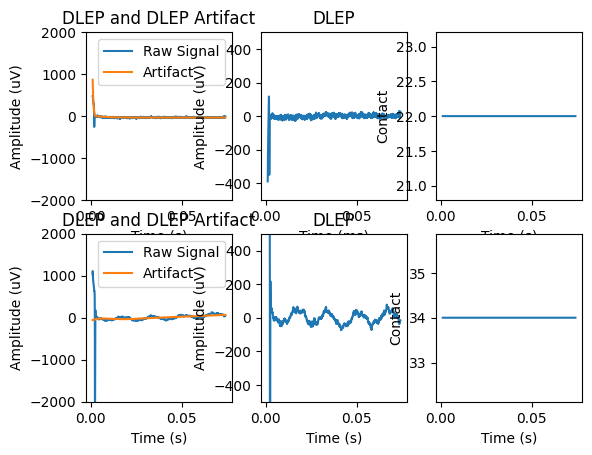

In [ ]:
Idx = int(np.floor((np.shape(input_data)[0])*np.random.rand()))

plt.figure()
plt.subplot(2,3,1)
plt.plot(time,input_data[Idx,:])
plt.plot(time,output_data[Idx,:])
plt.title('DLEP and DLEP Artifact')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.legend(['Raw Signal', 'Artifact'])
plt.ylim([-2000,2000])
plt.subplot(2,3,2)
plt.plot(time,(input_data[Idx,:] - output_data[Idx,:]))
plt.title('DLEP')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (uV)')
plt.ylim([-500,500])
plt.subplot(2,3,3)
plt.plot(time,categories[Idx]*np.ones(len(time)))
plt.ylabel('Contact')
plt.xlabel('Time (s)')
Idx = int(np.floor((np.shape(input_data)[0])*np.random.rand()))

plt.subplot(2,3,4)
plt.plot(time,input_data[Idx,:])
plt.plot(time,output_data[Idx,:])
plt.title('DLEP and DLEP Artifact')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.legend(['Raw Signal', 'Artifact'])
plt.ylim([-2000,2000])
plt.subplot(2,3,5)
plt.plot(time,(input_data[Idx,:] - output_data[Idx,:]))
plt.title('DLEP')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (uV)')
plt.ylim([-500,500])
plt.subplot(2,3,6)
plt.plot(time,categories[Idx]*np.ones(len(time)))
plt.ylabel('Contact')
plt.xlabel('Time (s)')
plt.show()




# Building neural network for artifact modelling

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input,Conv1D, Dense, Flatten, Reshape, Dropout, BatchNormalization, MaxPooling1D, UpSampling1D, Subtract, LeakyReLU, SimpleRNN, Embedding, LSTM, Activation, GRU, GlobalMaxPool1D, Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from sklearn.metrics import root_mean_squared_error
from keras.utils import to_categorical

import matplotlib.pyplot as plt

In [ ]:
import keras
def rrmse(x,y):
    rmse = K.sqrt(K.mean(K.square(y-x)))
    rms = K.sqrt(K.mean(K.square(x)))
    div = rmse/rms
    return div

def accuracy(x,y):
    return 

def zero_centering(x,y):
    rmse = K.sqrt(K.mean(K.square(y)))
    return rmse


In [ ]:
#clipping data to prevent overflow
clip_min = -np.exp(8)
clip_max = np.exp(8)

input_data = np.clip(input_data, clip_min, clip_max)
output_data = np.clip(output_data, clip_min, clip_max)   

input_data = input_data.reshape((input_data.shape[0],input_data.shape[1], 1))
output_data = output_data.reshape((output_data.shape[0],output_data.shape[1],1))
categories_data = to_categorical(categories)

print('Size of input dataset: ', input_data.shape)
print('Size of contacts dataset: ', categories_data.shape)
print('Size of output dataset: ',output_data.shape)

#splitting data into testing and training
X_train, X_test_temp, y_train, y_test_temp, categories_train, categories_test_temp,coordinates_train,coordinates_test_temp = train_test_split(input_data, output_data, categories_data, coordinates, test_size = 0.5, stratify=categories_data)

X_val,X_test,y_val,y_test,categories_val,categories_test,coordinates_val,coordinates_test = train_test_split(X_test_temp,y_test_temp,categories_test_temp,coordinates_test_temp, test_size = 0.5, stratify=categories_test_temp)


Size of input dataset:  (7533, 1606, 1)
Size of contacts dataset:  (7533, 120)
Size of output dataset:  (7533, 1606, 1)


In [ ]:
#Building encoder 
input = Input(shape=(input_data.shape[1],1))
x = Conv1D(128,3)(input)
x = LeakyReLU(negative_slope=0.2)(x)
x = MaxPooling1D(strides=2)(x)
x = BatchNormalization()(x)
x = Conv1D(64,3)(x)
x = LeakyReLU(negative_slope=0.2)(x)
x = MaxPooling1D(strides=2)(x)
x = BatchNormalization()(x)
x = Conv1D(32,3)(x)
x = LeakyReLU(negative_slope=0.2)(x)
x = MaxPooling1D(strides=2)(x)
x = BatchNormalization()(x)
x = Flatten()(x)
output_artifact = Dense(input_data.shape[1],activation='linear',name='OUTPUT_ARTIFACT')(x)
#output_artifact = Subtract()([input[:,:,0],x])
print(output_artifact.shape)

(None, 1606)


In [ ]:
import keras 

model_artifact = Model(inputs = input, outputs = output_artifact)
model_artifact.compile(optimizer='adam', loss=rrmse)
model_artifact.summary()


history_artifact = model_artifact.fit(X_train, y_train , epochs=10 , batch_size=15 , validation_data= (X_val,y_val))

test_loss = model_artifact.evaluate(X_val,y_val)
print(f'Test Loss Artifact: {test_loss}')


Model: "functional_140"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_104 (InputLayer)    │ (None, 1606, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_274 (Conv1D)             │ (None, 1604, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_51 (LeakyReLU)      │ (None, 1604, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_241               │ (None, 802, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_212         │ (None, 802, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_275 (Conv1D)             │ (None, 800, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_52 (LeakyReLU)      │ (None, 800, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_242               │ (None, 400, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_213         │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_276 (Conv1D)             │ (None, 398, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_53 (LeakyReLU)      │ (None, 398, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_243               │ (None, 199, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_214         │ (None, 199, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_109 (Flatten)           │ (None, 6368)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ OUTPUT_ARTIFACT (Dense)         │ (None, 1606)           │    10,228,614 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,260,838 (39.14 MB)

 Trainable params: 10,260,390 (39.14 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - loss: 0.8147 - val_loss: 0.2528
Epoch 2/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.3036 - val_loss: 0.2904
Epoch 3/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - loss: 0.2885 - val_loss: 0.2261
Epoch 4/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.3121 - val_loss: 0.2123
Epoch 5/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.2940 - val_loss: 0.2647
Epoch 6/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.2859 - val_loss: 0.2056
Epoch 7/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.2637 - val_loss: 0.2007
Epoch 8/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.2706 - val_loss: 0.2005
Epoch 9/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.2710 - val_loss: 0.2254
Epoch 10/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - loss: 0.2591 - val_loss: 0.1883
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.1950
Test Loss Artifact: 0.18729139864444733


Text(0.5, 1.0, 'Artifact RRMSE')

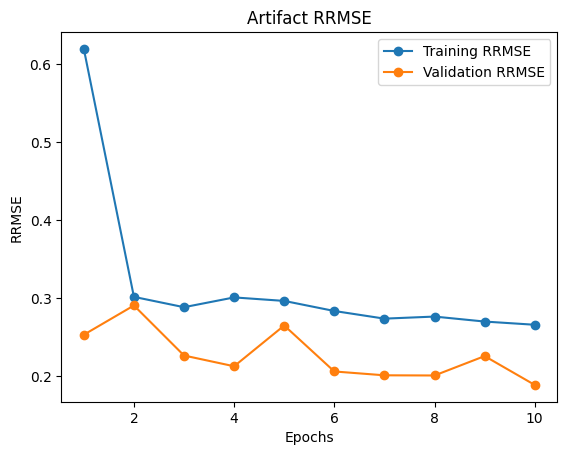

In [ ]:
artifact_train_loss = history_artifact.history['loss']
artifact_val_loss = history_artifact.history['val_loss']
epochs = range(1, len(artifact_train_loss) + 1)
plt.plot(epochs,artifact_train_loss,'-o')
plt.plot(epochs,artifact_val_loss,'-o')
plt.legend(['Training RRMSE','Validation RRMSE'])
plt.ylabel('RRMSE')
plt.xlabel('Epochs')
plt.title('Artifact RRMSE')

In [ ]:
model_predict = model_artifact.predict(X_val)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [ ]:
import random
from scipy.signal import savgol_filter

n_examples_to_plot = []
for i in range(0,3):
    n_examples_to_plot.append(random.randint(0,X_val.shape[0]-1))

print(n_examples_to_plot)
# Create a subplot with 3 rows and 2 columns
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
fig.suptitle('Evoked Potential Filtering with Convolutional Neural Network')


for i in range(0,3):
    # Plot pred vs real in the left column
    axs[i, 0].plot(time,X_val[n_examples_to_plot[i]].flatten(), label='Raw Evoked Potential',color='cyan',linewidth=2)
    axs[i, 0].plot(time,y_val[n_examples_to_plot[i]].flatten(), label='DLEP Artifact',color='red')
    axs[i, 0].plot(time,model_predict[n_examples_to_plot[i]].flatten(), label='Fitted Signal',color='black',linewidth=0.5)
    axs[i, 0].set_xlabel('Time (ms)')
    axs[i, 0].set_ylabel('Amplitude (uV)')
    axs[i, 0].set_title('Artifact Fitting')
    axs[i, 0].set_ylim([-4000,4000])
    axs[i, 0].legend()
    
    # Plot real vs real in the right column
    axs[i, 1].plot(time,(X_val[n_examples_to_plot[i]].flatten()- y_val[n_examples_to_plot[i]].flatten()), label='DLEP',color='orange',linewidth=2)
    axs[i, 1].plot(time,(X_val[n_examples_to_plot[i]].flatten() - model_predict[n_examples_to_plot[i]].flatten()), label='Fitted DLEP',color='black',linewidth=0.5)
    axs[i, 1].set_xlabel('Time (ms)')
    axs[i, 1].set_ylabel('Amplitude (uV)')
    axs[i, 1].set_title('DLEP')
    axs[i, 1].set_ylim([-500,500])

    axs[i, 1].legend()



plt.tight_layout()
plt.subplots_adjust(top=0.95) 
plt.show()

NameError: name 'X_val' is not defined

# Recreating X_val and X_test

In [ ]:
X_val = np.squeeze(X_val) - model_predict
X_val = savgol_filter(X_val,11,3)
X_val.shape

In [ ]:
X_test = np.squeeze(X_test) - model_artifact.predict(X_test)
X_test = savgol_filter(X_test,11,3)
X_test.shape

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


## Plotting DLEPs without artifact

[1325, 357, 1395]


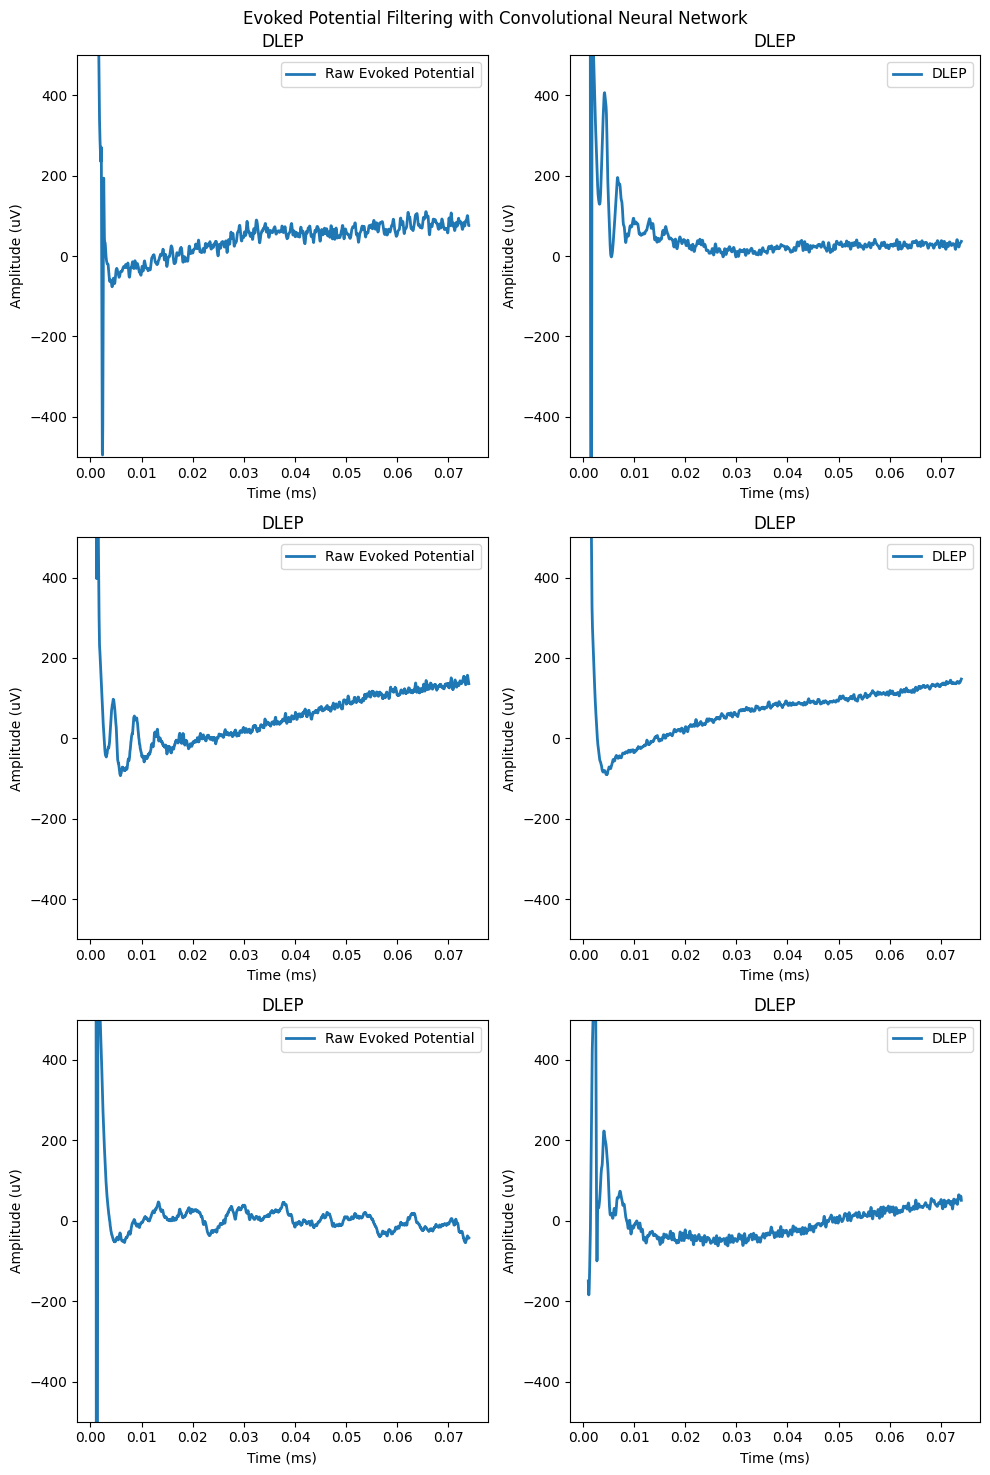

In [ ]:
import random
from scipy.signal import savgol_filter

n_examples_to_plot = []
for i in range(0,3):
    n_examples_to_plot.append(random.randint(0,X_val.shape[0]-1))

print(n_examples_to_plot)
# Create a subplot with 3 rows and 2 columns
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
fig.suptitle('Evoked Potential Filtering with Convolutional Neural Network')


for i in range(0,3):
    # Plot pred vs real in the left column
    axs[i, 0].plot(time,X_val[n_examples_to_plot[i]].flatten(), label='Raw Evoked Potential',linewidth=2)
    axs[i, 0].set_xlabel('Time (ms)')
    axs[i, 0].set_ylabel('Amplitude (uV)')
    axs[i, 0].set_title('DLEP')
    axs[i, 0].set_ylim([-500,500])
    axs[i, 0].legend()
    
    # Plot real vs real in the right column
    axs[i, 1].plot(time,(X_test[n_examples_to_plot[i]].flatten()), label='DLEP',linewidth=2)
    axs[i, 1].set_xlabel('Time (ms)')
    axs[i, 1].set_ylabel('Amplitude (uV)')
    axs[i, 1].set_title('DLEP')
    axs[i, 1].set_ylim([-500,500])

    axs[i, 1].legend()



plt.tight_layout()
plt.subplots_adjust(top=0.95) 
plt.show()

# Building classifier model

In [ ]:
#building classification model

input_classifier = Input(shape=(input_data.shape[1],1))
print(input_classifier.shape)
x = Conv1D(128,3,activation = 'leaky_relu')(input_classifier)
x = MaxPooling1D(pool_size = 2)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv1D(64,3,activation = 'leaky_relu')(x)
x = MaxPooling1D(pool_size = 2)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv1D(32,3,activation = 'leaky_relu')(x)
x = MaxPooling1D(pool_size = 2)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
output_classifier = Dense(120,activation='softmax')(x)
print(output_classifier.shape)

(None, 1606, 1)
(None, 120)


In [ ]:
# Check the shape of the data
print(f'X_val shape: {X_val.shape}')
print(f'Category_val shape: {categories_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'Category_test shape: {categories_test.shape}')

X_val shape: (1883, 1606)
Category_val shape: (1883, 120)
X_test shape: (1884, 1606)
Category_test shape: (1884, 120)


In [ ]:
classifier = Model(inputs = input_classifier, outputs = output_classifier)
classifier.compile(optimizer='adam', loss=['categorical_focal_crossentropy'],metrics=['precision'])
classifier.summary()

history_classifier = classifier.fit(X_val, categories_val , epochs=20  , batch_size=15 , validation_data= (X_test,categories_test))

test_loss = classifier.evaluate(X_test, categories_test)
print(f'Test Loss Artifact: {test_loss}')

Model: "functional_141"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_105 (InputLayer)    │ (None, 1606, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_277 (Conv1D)             │ (None, 1604, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_244               │ (None, 802, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_215         │ (None, 802, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 802, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_278 (Conv1D)             │ (None, 800, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_245               │ (None, 400, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_216         │ (None, 400, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 400, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_279 (Conv1D)             │ (None, 398, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_246               │ (None, 199, 32)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_217         │ (None, 199, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 199, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_110 (Flatten)           │ (None, 6368)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 120)            │       764,280 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 796,504 (3.04 MB)

 Trainable params: 796,056 (3.04 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 1.1840 - precision: 0.0892 - val_loss: 0.6878 - val_precision: 0.3320
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.7686 - precision: 0.2559 - val_loss: 0.6801 - val_precision: 0.3283
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.6653 - precision: 0.3293 - val_loss: 0.6189 - val_precision: 0.5429
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.6002 - precision: 0.3803 - val_loss: 0.6316 - val_precision: 0.3686
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.5315 - precision: 0.4481 - val_loss: 0.5958 - val_precision: 0.3573
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.4971 - precision: 0.4961 - val_loss: 0.5493 - val_precision: 0.4932
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.4695 - precision: 0.5462 - val_loss: 0.5808 - val_precision: 0.4947
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.4222 - precision: 0.

Text(0.5, 0, 'Epochs')

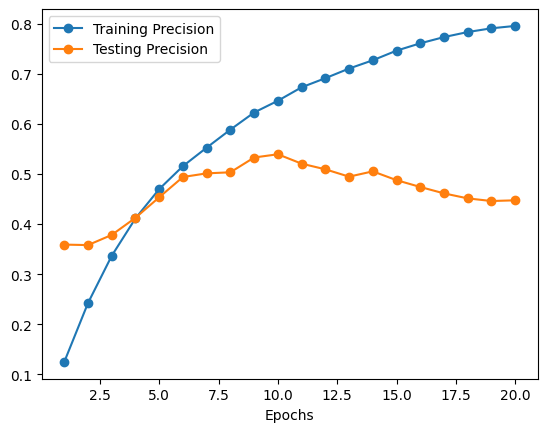

In [ ]:
epochs = range(1, len(history_classifier.history['precision']) + 1)
#plt.plot(epochs,history_contact.history['accuracy'])
#plt.plot(epochs,history_contact.history['val_accuracy'])
plt.plot(epochs,savgol_filter(history_classifier.history['precision'],11,3),'-o')
plt.plot(epochs,savgol_filter(history_classifier.history['val_precision'],11,3),'-o')
plt.legend({'Training Precision','Testing Precision'})
plt.xlabel('Epochs')

# Dimensionality reduction, and classification using "encoder"

In [ ]:
#Building auto encoder
#building classification model

input_encoder = Input(shape=(input_data.shape[1],1))
print(input.shape)
x = Conv1D(128,3,activation = 'relu')(input_encoder)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.3)(x)
x = Conv1D(64,3,activation = 'relu')(x)
x = MaxPooling1D(pool_size = 2)(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
output_latent_space = Dense(20,activation = 'linear')(x)
x = Dense(32)(output_latent_space)
x = Reshape((32,1))(x)
x = Conv1D(32,3,activation = 'relu')(x)
x = MaxPooling1D(pool_size = 2)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
output_encoder = Dense(120,activation='softmax')(x)
print(output_encoder.shape)

(None, 1606, 1)
(None, 120)


In [ ]:
autoencoder = Model(inputs = input_encoder, outputs = output_encoder)
encoder = Model(inputs = input_encoder, outputs = output_latent_space)

decoder = Model(inputs = autoencoder.layers[3].output, outputs = output_encoder)

autoencoder.compile(optimizer='adam', loss=['categorical_focal_crossentropy'],metrics=['precision'])
autoencoder.summary()


history_autoencoder = autoencoder.fit(X_val, categories_val , epochs=20  , batch_size=15 , validation_data= (X_test,categories_test))

test_loss = autoencoder.evaluate(X_test, categories_test)
print(f'Test Loss Artifact: {test_loss}')

Model: "functional_142"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_106 (InputLayer)    │ (None, 1606, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_280 (Conv1D)             │ (None, 1604, 128)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_247               │ (None, 802, 128)       │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 802, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_281 (Conv1D)             │ (None, 800, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_248               │ (None, 400, 64)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 400, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_111 (Flatten)           │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 20)             │       512,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_192 (Dense)               │ (None, 32)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_37 (Reshape)            │ (None, 32, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_282 (Conv1D)             │ (None, 30, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_249               │ (None, 15, 32)         │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_218         │ (None, 15, 32)         │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_112 (Flatten)           │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_193 (Dense)               │ (None, 120)            │        57,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 595,820 (2.27 MB)

 Trainable params: 595,756 (2.27 MB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.9849 - precision: 0.0544 - val_loss: 0.7423 - val_precision: 0.0921
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.7504 - precision: 0.2453 - val_loss: 0.6462 - val_precision: 0.3696
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.6604 - precision: 0.4451 - val_loss: 0.5974 - val_precision: 0.4627
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.5909 - precision: 0.4912 - val_loss: 0.5611 - val_precision: 0.5409
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.5214 - precision: 0.5305 - val_loss: 0.5192 - val_precision: 0.6973
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.4847 - precision: 0.5286 - val_loss: 0.4829 - val_precision: 0.7238
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.4670 - precision: 0.5883 - val_loss: 0.4623 - val_precision: 0.7549
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.4046 - precision: 0.

Text(0.5, 0, 'Epochs')

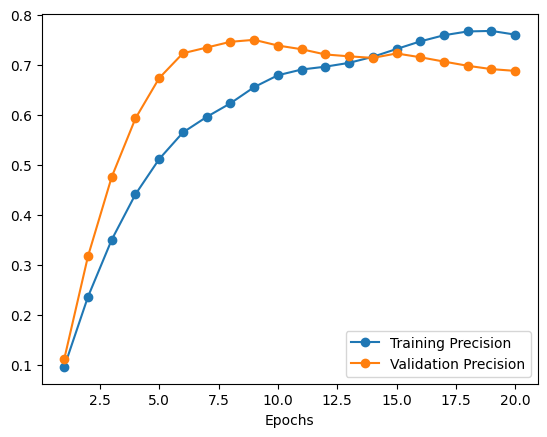

In [ ]:
epochs = range(1, len(history_autoencoder.history['precision']) + 1)
#plt.plot(epochs,history_contact.history['accuracy'])
#plt.plot(epochs,history_contact.history['val_accuracy'])
plt.plot(epochs,savgol_filter(history_autoencoder.history['precision'],11,3),'-o')
plt.plot(epochs,savgol_filter(history_autoencoder.history['val_precision'],11,3),'-o')
plt.legend({'Training Precision','Validation Precision'})
plt.xlabel('Epochs')

# Latent space visualization

In [ ]:
latent_space = encoder.predict(X_test)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
latent_space.shape

(1884, 20)

In [ ]:
categories_umap = np.argmax(categories_test,axis =1 )
categories_umap.shape

(1884,)

In [ ]:
import umap.umap_ as umap
mapper = umap.UMAP(n_neighbors = 10 ,min_dist = 1, metric='cosine').fit(latent_space)

<Axes: >

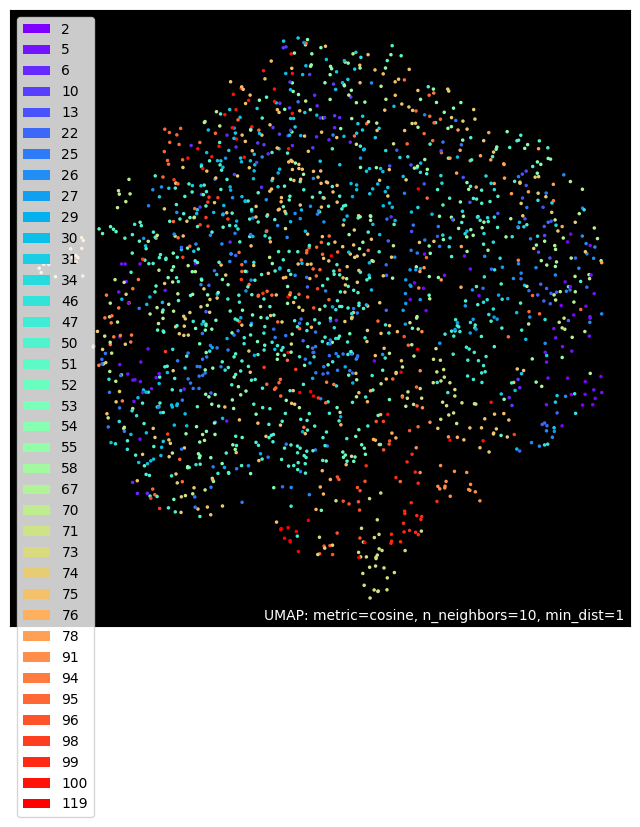

In [ ]:
import umap.plot
umap.plot.points(mapper,labels = categories_umap,theme='fire')


In [ ]:
#from sklearn documentation
from matplotlib import ticker

def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(10, 10), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()
def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=10, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

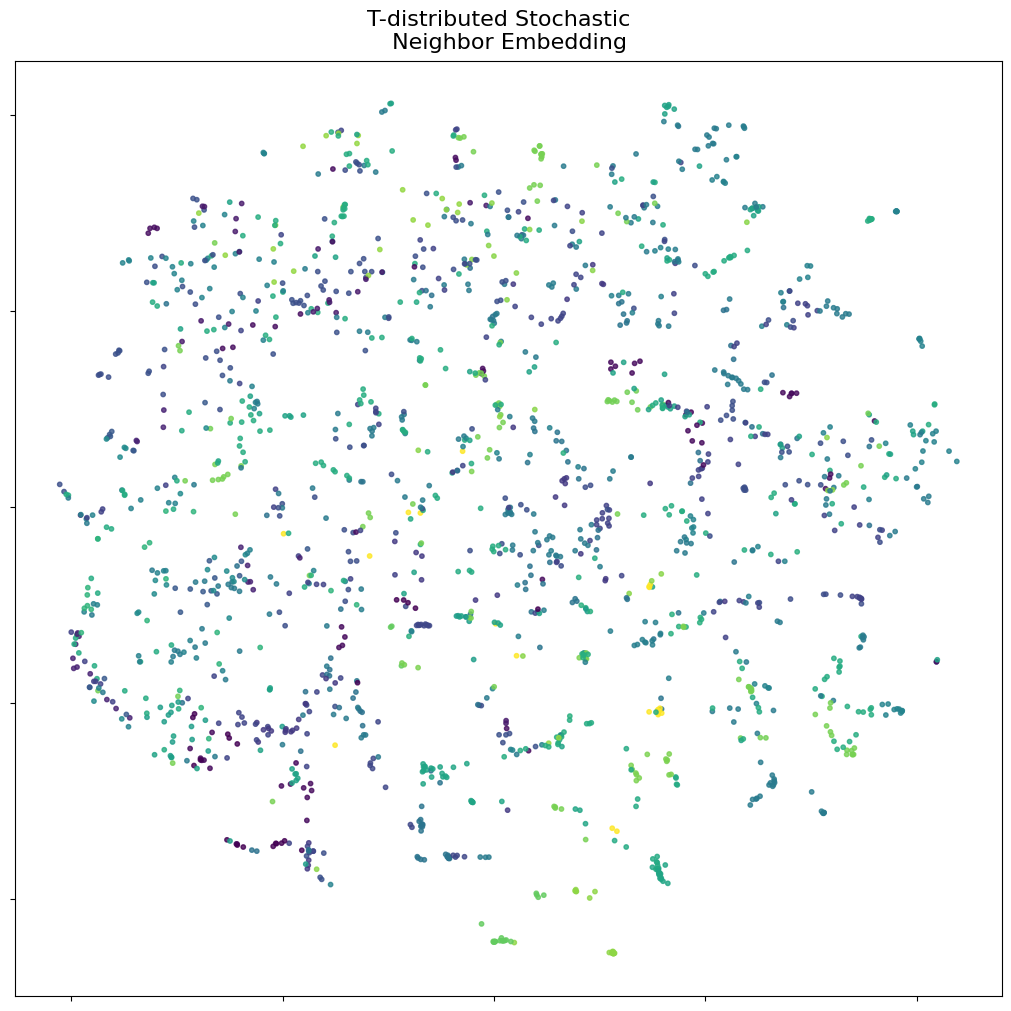

In [ ]:
from sklearn import manifold
t_sne = manifold.TSNE(
    n_components=2,
    perplexity=20,
    init="random",
    max_iter=300,
    random_state=0,
)
S_t_sne = t_sne.fit_transform(latent_space)

plot_2d(S_t_sne,categories_umap, "T-distributed Stochastic  \n Neighbor Embedding")

In [ ]:
pred = autoencoder.predict(X_test)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [ ]:
print(pred.shape)
print(categories_test.shape)
contact_pred_new = np.argmax(pred,axis =1 )
contact_test_new = np.argmax(categories_test,axis=1)
print(contact_pred_new.shape)
print(contact_test_new.shape)

(1884, 120)
(1884, 120)
(1884,)
(1884,)


In [ ]:
X_train_temp = np.squeeze(X_train) - model_artifact.predict(X_train)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [ ]:
pred_classifier  = classifier.predict(X_train_temp)
pred = autoencoder.predict(X_test)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [ ]:
print(pred.shape)
print(pred_classifier.shape)

pred = np.argmax(pred,axis=1)
categories_test_array = np.argmax(categories_test,axis=1)
pred_classifier = np.argmax(pred_classifier,axis=1)
categories_train_array = np.argmax(categories_train,axis=1)

print(pred.shape)
print(categories_test_array.shape)
print(pred_classifier.shape)
print(categories_train_array.shape)

(1884, 120)
(3766, 120)
(1884,)
(1884,)
(3766,)
(3766,)


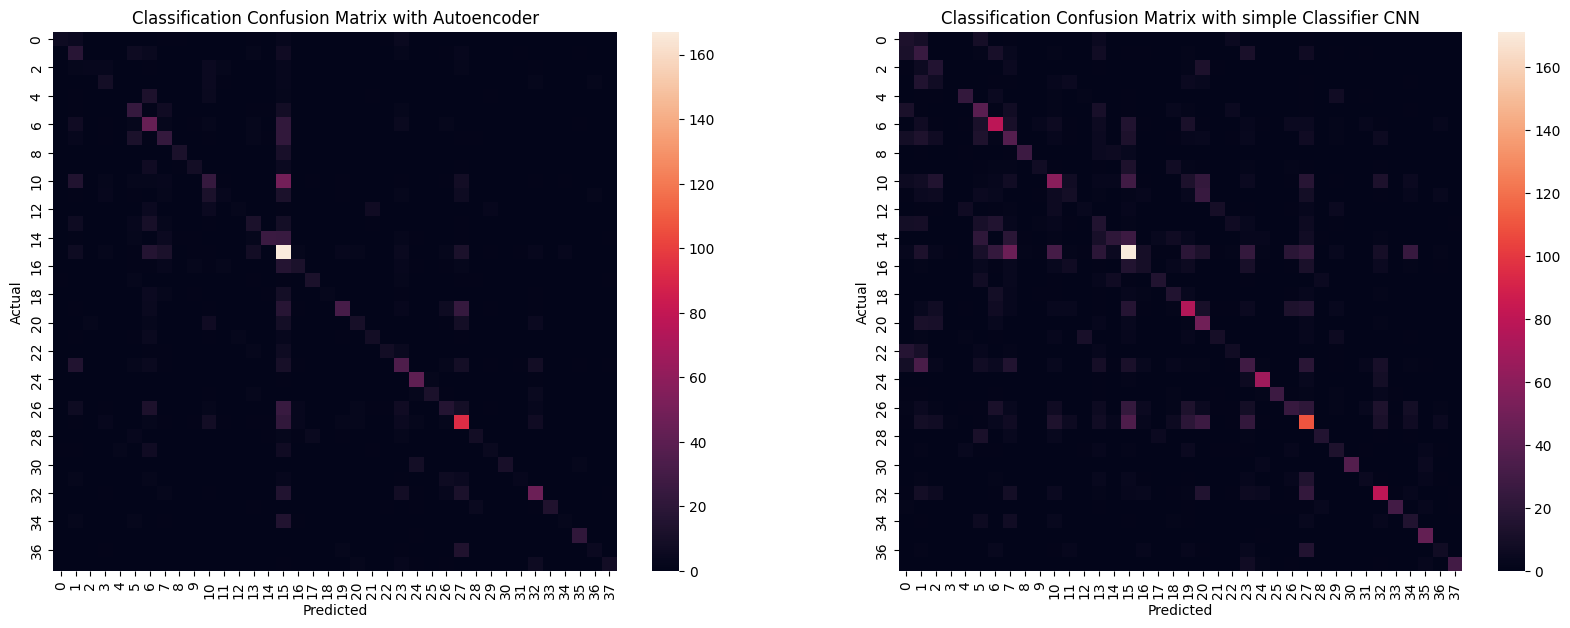

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_autoencoder = confusion_matrix(y_true = categories_test_array,y_pred = pred)
cm_classifier = confusion_matrix(y_true = categories_train_array, y_pred = pred_classifier)

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
sns.heatmap(cm_autoencoder)
plt.title('Classification Confusion Matrix with Autoencoder')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1,2,2)
sns.heatmap(cm_classifier)
plt.title('Classification Confusion Matrix with simple Classifier CNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Is dimension reduction to three dimensions enough? Could three dimensions be enough for a linear transformation?

In [ ]:
latent_space.shape

(1884, 20)

In [ ]:
latent_space_test = encoder.predict(X_train_temp)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [ ]:
from sklearn.linear_model import LinearRegression
linear_Regression = LinearRegression().fit(latent_space,coordinates_test)

In [ ]:
pred_regression = linear_Regression.predict(latent_space_test)

In [ ]:
linear_Regression.score(latent_space_test,coordinates_train)

0.18097741901874542

In [ ]:
linear_Regression = LinearRegression().fit(X_train_temp,categories_train)

In [ ]:
linear_Regression.score(X_test,categories_test)

0.019437089800441173

No

# Why a neural network?

In [ ]:
from sklearn.linear_model import MultiTaskLassoCV

In [ ]:
lasso_regression = MultiTaskLassoCV(max_iter = 1000).fit(X_val,coordinates_val)

c:\Users\Prerana Lakshmanan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9066858565129223, tolerance: 1.6738221745680992
  model = cd_fast.enet_coordinate_descent_multi_task(
c:\Users\Prerana Lakshmanan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2265248188014084, tolerance: 1.6738221745680992
  model = cd_fast.enet_coordinate_descent_multi_task(
c:\Users\Prerana Lakshmanan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9749601205112413, tolerance: 1.673822174568

In [ ]:
lasso_regression.score(X_test,coordinates_test)

0.18563332522531809